# 1. Developing a model
Data source: https://www.kaggle.com/datasnaek/league-of-legends.

In [259]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

# sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score #
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, brier_score_loss, log_loss, precision_score, recall_score)
from sklearn.metrics import classification_report

games_raw = pd.read_csv('C:/Users/xsoni/Desktop/league_of_legends_ranked_games/games.csv')

### Data handling summary
- Removed duplicate rows, we don't want the same game to appear multiple times in our data.
- Renamed team2 to team0 and changed values correspondingly for convenience.
- Kept only variables relating to team statistics to keep it simple.

In [197]:
# drop duplicate values
games_temp = games_raw.drop_duplicates()

# we keep only the variables that we want to keep for our model and encode team 1 as 1 and team 2 as 0 instead of 2
games_part1 = games_temp[['winner', 'firstBlood', 'firstTower', 'firstInhibitor'
                          , 'firstBaron' ,'firstDragon', 'firstRiftHerald']]%2

games_part2 = games_temp[['t1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills'
                       ,'t2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills']]

games_part2 = games_part2.rename(columns={'t2_towerKills': 't0_towerKills','t2_inhibitorKills': 't0_inhibitorKills'
                                         ,'t2_baronKills': 't0_baronKills' ,'t2_dragonKills': 't0_dragonKills'
                                         ,'t2_riftHeraldKills': 't0_riftHeraldKills'}, errors="raise")

games = pd.concat([games_part1, games_part2], axis=1)
games

,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t0_towerKills,t0_inhibitorKills,t0_baronKills,t0_dragonKills,t0_riftHeraldKills
0,1,0,1,1,1,1,0,11,1,2,3,0,5,0,0,1,1
1,1,1,1,1,0,1,1,10,4,0,2,1,2,0,0,0,0
2,1,0,1,1,1,0,0,8,1,1,1,0,2,0,0,1,0
3,1,1,1,1,1,1,0,9,2,1,2,0,0,0,0,0,0
4,1,0,1,1,1,1,0,9,2,1,3,0,3,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,0,1,0,0,0,0,0,2,0,0,0,0,10,2,0,4,0
51486,0,1,1,0,0,0,0,5,4,0,2,0,11,7,4,4,1
51487,0,0,0,0,0,1,0,0,0,0,1,0,10,2,0,2,0
51488,0,0,0,0,0,0,0,0,0,0,0,0,11,3,0,1,0


In [230]:
print('Correlations against the winner variable: \n' , games.corr()['winner'].sort_values())

Correlations against the winner variable: 
 t0_towerKills        -0.785722
t0_inhibitorKills    -0.660696
t0_dragonKills       -0.497055
t0_baronKills        -0.398692
t0_riftHeraldKills   -0.226131
firstBlood            0.180038
firstRiftHerald       0.218057
t1_riftHeraldKills    0.218057
firstDragon           0.344566
t1_baronKills         0.369883
firstBaron            0.387115
firstTower            0.406367
t1_dragonKills        0.472635
t1_inhibitorKills     0.649636
firstInhibitor        0.724602
t1_towerKills         0.771571
winner                1.000000
Name: winner, dtype: float64


Note that the correlations are more or less symmetric with respect to team for the team specific variables.

In [199]:
# train test split
X = games.drop(['winner'], axis='columns')
y = games['winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    shuffle=True, random_state=2) # gives us 10,2k test games

## Models that we will consider:
### Logistic regression (linear in input variables, default settings except for removing intercept)  

This model is included because of the high correlations between some of the inputs with the target variable. The data is constrained by the game mechanics such that there is an absence of outliers, this usually improves the model performance and allows the model to generalize to new data.

OBS! There may exist major issues with this model - multicollinearity, residuals not being normal, input and target variables having a slight non-linear relationship etc - which we will not consider because it is out of scope for this project. The model performance may suffer from this.

### Decision tree and random forest (with parameters hypertuned, using a grid search with cross validation, for accuracy)  
In comparison to the logistic regression these models have the potential to pick up on non-linear relationships between the input variables and the target variable. The models handles collinearity well. Again, because the data is constrained by the game mechanics we can expect these models to generalize well to new data.

In [254]:
# logistic regression
print('logistic regression: ')
log_reg = LogisticRegression(fit_intercept=False)
log_reg_scores = cross_val_score(log_reg, X_train, y_train, cv=10)
print('mean acc: ', log_reg_scores.mean(), '\nrange: ', log_reg_scores.max()-log_reg_scores.min())


# decision tree
print('\ndecision tree: ')
dt_criterion=['gini', 'entropy']
dt_max_depth=range(5,9,1)
dt_splitter=['best', 'random']
dt=DecisionTreeClassifier()
dt_grid=GridSearchCV(estimator=dt,cv=10,
                                param_grid=dict(criterion=dt_criterion,max_depth=dt_max_depth,splitter=dt_splitter))
dt_grid.fit(X_train,y_train)
print('mean accuracy with tuned hyperparameters: ', dt_grid.best_score_)
print('tuned hyperparameters: ', dt_grid.best_params_)


# random forest
print('\nrandom forest: ')
rf_criterion=["gini","entropy", 'log_loss']
rf_max_depth=range(1,4,1)
rf=RandomForestClassifier()
rf_grid=GridSearchCV(estimator=rf,cv=10, 
                     param_grid=dict(criterion=rf_criterion,max_depth=rf_max_depth))
rf_grid.fit(X_train,y_train)
print("mean accuracy with tuned hyperparameters: ", rf_grid.best_score_)
print("tuned hyperparameters: ", rf_grid.best_params_)

logistic regression: 
mean acc:  0.9632731668019329 
range:  0.0071008814887365546

decision tree: 
mean accuracy with tuned hyperparameters:  0.9682926055886363
tuned hyperparameters:  {'criterion': 'gini', 'max_depth': 8, 'splitter': 'best'}

random forest: 
mean accuracy with tuned hyperparameters:  0.9580089239795386
tuned hyperparameters:  {'criterion': 'gini', 'max_depth': 3}


## Model comparison

In [256]:
log_reg = LogisticRegression(fit_intercept=False)
dt = DecisionTreeClassifier(criterion='gini',max_depth=8, splitter='best')
rf = RandomForestClassifier(max_depth=3, criterion='gini')

classifier_list = [
    (log_reg, "Logistic Regression ")
    ,(dt, "Decision Tree")
    ,(rf, "Random Forest")
            ]

scores = defaultdict(list)
for i, (clf, name) in enumerate(classifier_list):
    clf.fit(X_train, Y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [accuracy_score, precision_score, recall_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "")
        scores[score_name].append(metric(Y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")

score_df.round(decimals=3)

,accuracy,precision,recall
Classifier,,,
Logistic Regression,0.962,0.965,0.960
Decision Tree,0.968,0.970,0.967
Random Forest,0.961,0.976,0.946


### Notes:
- Accuracy is similar for all models, especially logistic regression and the decision tree, but the decision tree has the highest accuracy. It is very much possible that the logistic regression model would have outperformed the decision tree model in terms of accuracy had we feature engineered such that the logistic regression model could better pick up non-linear relationships which may exist between the target variable and predictor variables.
- Precision and recall are almost equal for all models. This is to be expected if the data is balanced in terms of wins and losses for both teams in the training data. In fact, we could have used a stratified cross validation to make sure of this. One expects precision and recall to be alike for our models because the features used are symmetric.

## Test data performance


In [266]:
dt = DecisionTreeClassifier(criterion='gini',max_depth=8, splitter='best')
dt.fit(X_train, y_train)
print(classification_report(y_test, dt.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.966     0.969     0.967      5038
           1      0.970     0.967     0.968      5173

    accuracy                          0.968     10211
   macro avg      0.968     0.968     0.968     10211
weighted avg      0.968     0.968     0.968     10211



### Notes:
- The accuracy is the same on the test data as for the mean of cross validation accuracies.
# VAD MER VILL JAG GÖRA HÄR? FINNS DET NÅGON PLOT?

# 2. Discussion


From a classification standpoint we (often) assume a decision-rule “if 𝑝 > 0.5 classify as A otherwise B”. Such a decision rule may be good for classification but in the context of odds we are more interested in the uncertainty of the prediction 𝑝 and if the prediction is close to the true quantity 𝑝. Discuss if your model would be applicable in this setting. Would you evaluate your model differently if your aim is to compare the prediction 𝑝 and the true ? Can you perform such a comparison? Obs. 𝑝 this question is essentially open-ended and will be discussed further in person!

# BÖRJA MED ATT DISKUTERA DET OVAN, SEN GÅ IN PÅ EN LOG LOSS / BRIER SCORE RANT

- true quantity $\hat{p}$ can not be known, hence we can not know if our prediction is close to the true quantity in terms of a distance between $d(\hat{p},p)$
- we can however evaluate how well the model predicts the winner (we actually have data on that!)
- any smart work arounds? what is even meant by true p? a true underlying probability that a team will win... such can not be known, only modeled


### Do we want to focus on log loss or brier score?
- More on Brier score and log-loss:  
https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/#:~:text=Log%20loss%20quantifies%20the%20average,between%20predicted%20and%20expected%20probabilities  
and  
https://towardsdatascience.com/introduction-to-probabilistic-classification-a-machine-learning-perspective-b4776b469453  
see also sklearns pages on both for more
- More on cross validation  
 https://machinelearningmastery.com/training-validation-test-split-and-cross-validation-done-right/
 
- More on calibration plots  
https://scikit-learn.org/stable/modules/calibration.html  
and  
https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html

In [ ]:
rf2=RandomForestClassifier()
grid_rf2=GridSearchCV(estimator=rf2,cv=10, scoring='neg_brier_score', 
                      param_grid=dict(criterion=criterion,max_depth=max_depth))

rf3=RandomForestClassifier()
grid_rf3=GridSearchCV(estimator=rf2,cv=10, scoring='neg_log_loss', 
                      param_grid=dict(criterion=criterion,max_depth=max_depth))

criterion=["gini","entropy", 'log_loss']
max_depth=range(1,5,1)
rf=RandomForestClassifier()
grid_rf2.fit(X_train,y_train)
print("best score: ", grid_rf2.best_score_)
print("best param: ", grid_rf2.best_params_)

grid_rf3.fit(X_train,y_train)
print("best score: ", grid_rf3.best_score_)
print("best param: ", grid_rf3.best_params_)

In [ ]:
scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, Y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss]:
        score_name = metric.__name__.replace("_", " ").replace("score", "")
        scores[score_name].append(metric(Y_test, y_prob[:, 1]))

    for metric in [accuracy_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "")
        scores[score_name].append(metric(Y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    
score_df.round(decimals=3)

### Probability calibration plot
Say our model that team 1 has 80% win probability given a certain game state. If we look at the frequency of games in that game state, how often did team 1 actually win?

# Lägg till trädmodeller som hypertunats för logloss/brier score

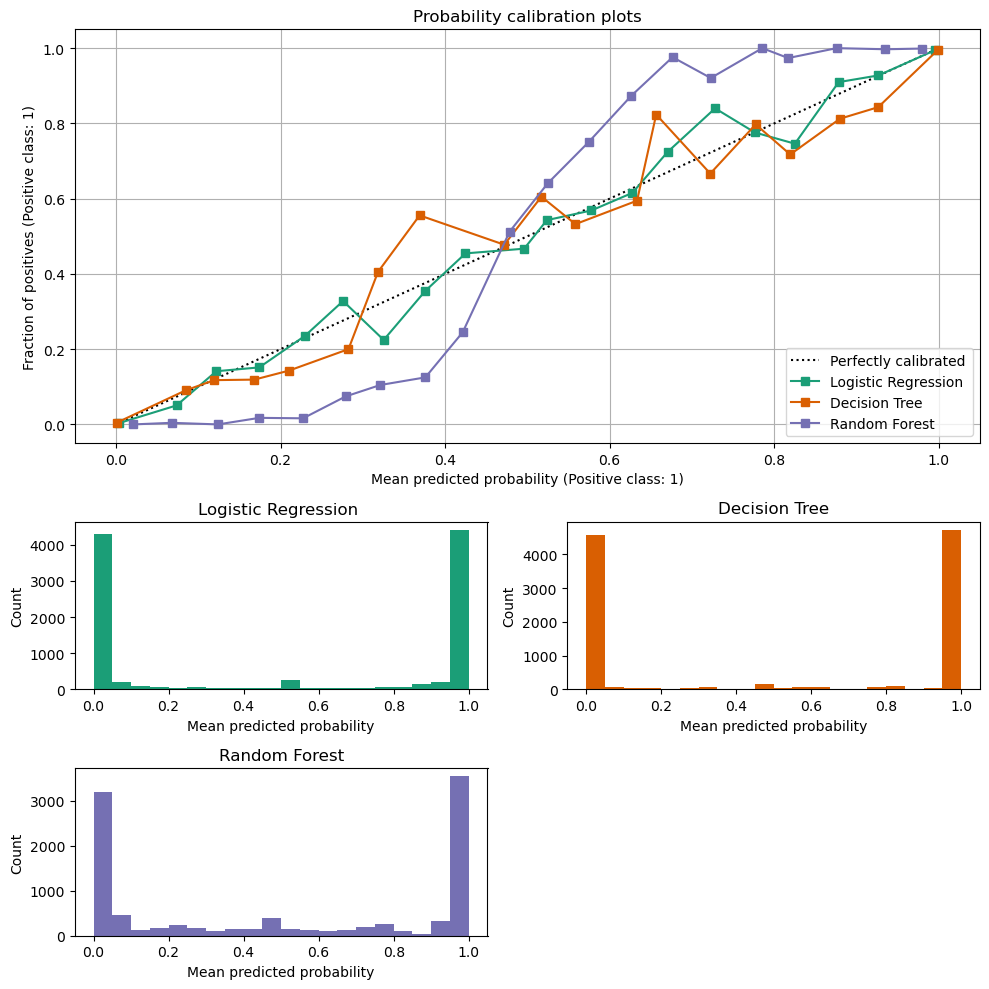

In [267]:
log_reg = LogisticRegression(fit_intercept=False)
dt = DecisionTreeClassifier(criterion='gini',max_depth=8, splitter='best')
rf = RandomForestClassifier(max_depth=3, criterion='gini')

classifier_list = [
    (log_reg, "Logistic Regression ")
    ,(dt, "Decision Tree")
    ,(rf, "Random Forest")
            ]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(classifier_list):
    clf.fit(X_train, Y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        Y_test,
        n_bins=20,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Probability calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=20,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

- Model mostly just makes very sure predictions with <0.05 or >0.95 probability. This is not totally unexpected as the data we have is from finished games. This however means that we have few observations in the bins where the model predicted something inbetween and hence the observed calibration curves are prone to high variation, hence the squiggly-ness.

# 3. Given more time I would expand the project by looking into:
- Champion type setup for both teams and length of game:
In my experience playing hon and dota, sometimes one team has problems ending the game and as time progresses the team that was losing turns the game around because they are 3-5 carrys that are getting well-equipped.
- Different model for predicting outcome given early surrender (i.e before the pre-requiste of killing at least 5 towers and 1 inhibitor such that the nexus can be attacked)

### Notes on dropped variables:
- creationTime: no predictive power unless our model takes chronological order into account (ex skill development)
- selection of champions and bans: there is likely signal in the choice of champions. 
- gameDuration: can probably be very useful for more complex modeling and synergies with other variables (ex: team setup, if a team does not end "early" against 5 carrys then they usually end up losing).